## Import Libraries

In [2]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

%matplotlib inline

## Load the Data

In [3]:
df = pd.read_csv('../../../data/data_saudi_used_cars.csv')

In [4]:
df.shape

(5624, 11)

In [5]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [6]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price


In [7]:
# Completeness
df.isnull().sum()

Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

In [8]:
# Accurecy types
df.dtypes

Type            object
Region          object
Make            object
Gear_Type       object
Origin          object
Options         object
Year             int64
Engine_Size    float64
Mileage          int64
Negotiable        bool
Price            int64
dtype: object

In [9]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = ['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']
numeric_features = ['Year', 'Engine_Size', 'Mileage']

In [10]:
for i in categorical_features:
   print (df[i].value_counts())

Type
Land Cruiser    269
Camry           233
Hilux           207
Accent          174
Yukon           162
               ... 
Nativa            1
360               1
GC7               1
CT5               1
S8                1
Name: count, Length: 347, dtype: int64
Region
Riyadh            2270
Dammam             924
Jeddah             732
Qassim             225
Al-Medina          214
Al-Ahsa            166
Aseer              163
Makkah             153
Taef               103
Tabouk              97
Khobar              76
Abha                64
Jazan               60
Hail                58
Jubail              56
Najran              42
Hafar Al-Batin      39
Al-Baha             35
Yanbu               27
Al-Jouf             27
Arar                22
Besha               16
Qurayyat            13
Al-Namas            12
Wadi Dawasir        12
Sakaka              10
Sabya                4
Name: count, dtype: int64
Make
Toyota          1430
Hyundai          668
Ford             530
Chevrolet     

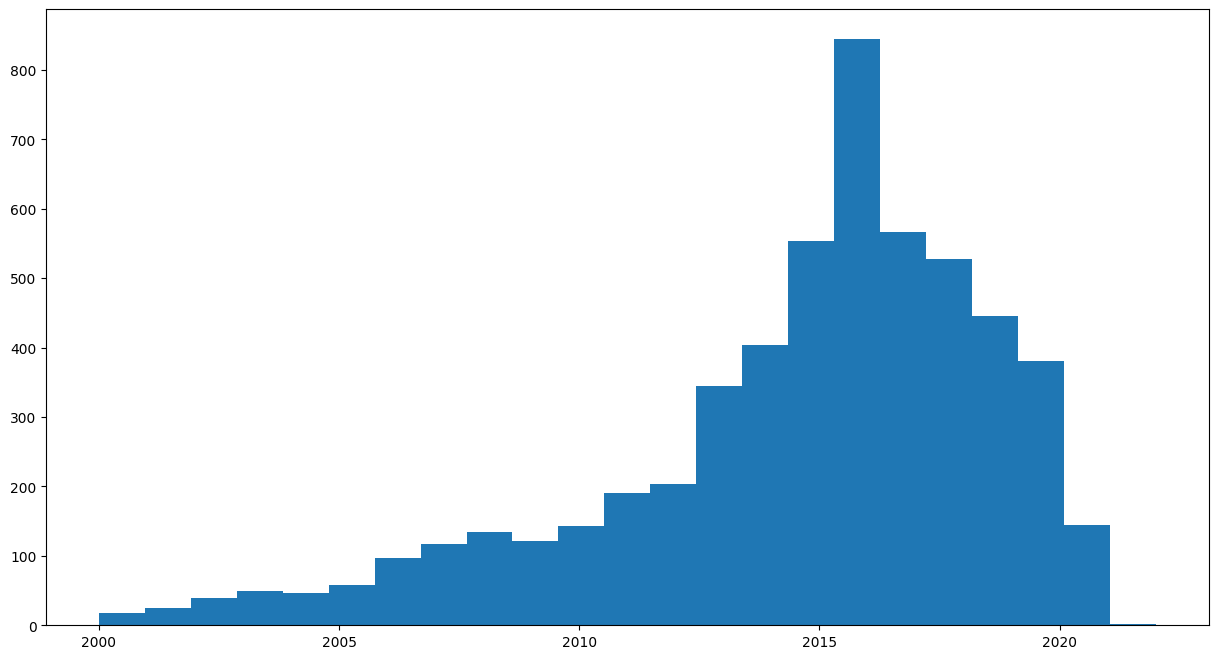

In [11]:
plt.figure(figsize=(15,8))
# plt.boxplot(df['Price']);
# plt.hist(df['Year'], bins=50);
plt.hist(df[(df['Year']>=2000)]['Year'], bins=23);

In [12]:
df = df[df['Year']>=2005]

In [13]:
# Calculate the frequency of each 'Type'
type_counts = df['Type'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['Type'].isin(type_counts[type_counts >= 3].index)]

In [14]:
df.shape

(5092, 11)

In [15]:
# Calculate the frequency of each 'Make'
make_counts = df['Make'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['Make'].isin(make_counts[make_counts >=3].index)]

In [16]:
df.shape

(5092, 11)

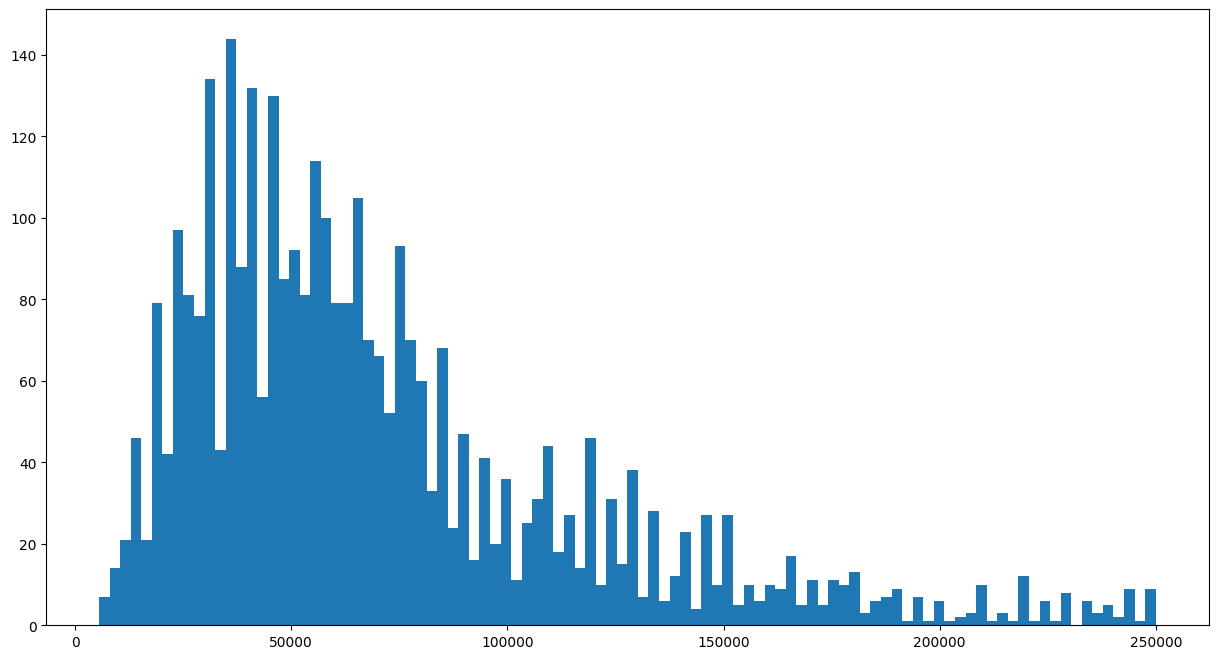

In [17]:
plt.figure(figsize=(15,8))
# plt.boxplot(df['Price']);
# plt.hist(df['Price'], bins=100);
plt.hist(df[(df['Price']<=250000) & (df['Price']>5000)]['Price'], bins=100);
#plt.hist(df[(df['Price']<=400000) & (df['Price']>=5000)]['Price'], bins=100);

In [18]:
df = df[(df['Price']<=250000) & (df['Price']>=5000)]

In [19]:
df.shape

(3335, 11)

In [20]:
df[df['Mileage']<1000]

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
7,Sonata,Riyadh,Hyundai,Automatic,Saudi,Full,2016,2.4,155,False,48000
10,C300,Makkah,Chrysler,Automatic,Saudi,Full,2013,5.7,200,False,55000
20,Sunny,Riyadh,Nissan,Manual,Saudi,Standard,2011,1.4,290,False,7000
26,Spark,Dammam,Chevrolet,Automatic,Saudi,Semi Full,2017,1.4,108,False,20000
31,Corolla,Jazan,Toyota,Automatic,Saudi,Semi Full,2013,1.6,296,False,30000
...,...,...,...,...,...,...,...,...,...,...,...
5575,Tahoe,Jeddah,Chevrolet,Automatic,Saudi,Full,2013,5.3,206,False,77000
5589,Land Cruiser,Tabouk,Toyota,Automatic,Gulf Arabic,Full,2013,4.6,186,False,138000
5606,Land Cruiser,Al-Baha,Toyota,Automatic,Gulf Arabic,Full,2006,4.6,285,False,65000
5607,C300,Riyadh,Chrysler,Automatic,Saudi,Full,2013,5.7,210,False,48000


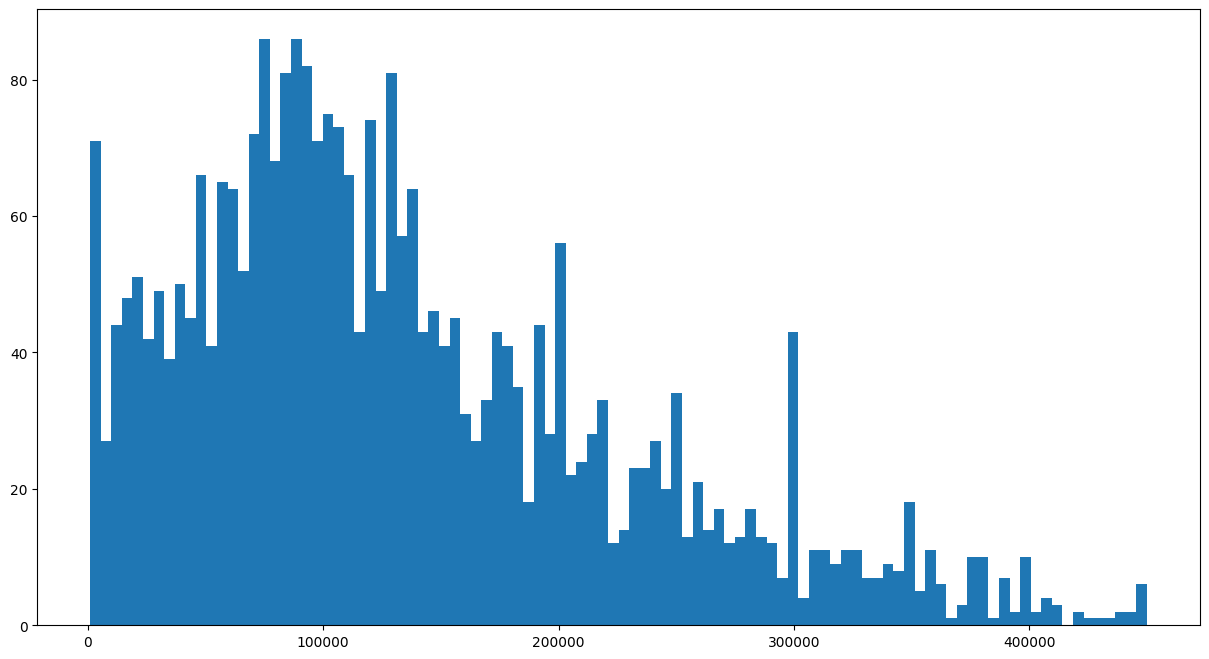

In [21]:
plt.figure(figsize=(15,8))
#plt.boxplot(df['Mileage']);
plt.hist(df[(df['Mileage']<=450000) & (df['Mileage']>=1000)]['Mileage'], bins=100);
# plt.hist(df['Mileage'], bins=100);

In [22]:
df = df[(df['Mileage']<=450000) & (df['Mileage']>=1000)]
df.shape

(3051, 11)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [23]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000


In [24]:
categorical_features

['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']

In [25]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [26]:
df.shape

(3051, 268)

In [27]:
df.head(2)

,Year,Engine_Size,Mileage,Negotiable,Price,Type_3,Type_300,Type_3008,Type_5,Type_500,...,Make_Volkswagen,Gear_Type_Automatic,Gear_Type_Manual,Origin_Gulf Arabic,Origin_Other,Origin_Saudi,Origin_Unknown,Options_Full,Options_Semi Full,Options_Standard
1,2014,8.0,80000,False,120000,False,False,False,False,False,...,False,True,False,False,False,True,False,True,False,False
3,2015,2.4,220000,False,42000,False,False,False,False,False,...,False,True,False,False,False,True,False,False,True,False


#### 3. Feature selection

In [28]:
# sns.heatmap(df.corr(), annot=True);

In [29]:
correlation = df.corr()
print(correlation['Price'].sort_values(ascending=False))

Price                1.000000
Engine_Size          0.371715
Year                 0.344185
Options_Full         0.343589
Type_Land Cruiser    0.297895
                       ...   
Origin_Saudi        -0.224844
Make_Hyundai        -0.229730
Options_Standard    -0.313551
Mileage             -0.347066
Negotiable                NaN
Name: Price, Length: 268, dtype: float64


In [30]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['Price']) > threshold]['Price'].index
selected_features

Index(['Year', 'Engine_Size', 'Mileage', 'Price', 'Type_Land Cruiser',
       'Make_Hyundai', 'Make_Lexus', 'Make_Mercedes', 'Origin_Gulf Arabic',
       'Origin_Saudi', 'Options_Full', 'Options_Standard'],
      dtype='object')

In [31]:
selected_features = ['Year', 'Engine_Size', 'Mileage', 'Price', 'Type_Land Cruiser',
       'Make_Hyundai', 'Make_Lexus', 'Make_Mercedes', 'Origin_Gulf Arabic',
       'Origin_Saudi', 'Options_Full', 'Options_Standard']

In [32]:
df = df[selected_features]
df.head()

,Year,Engine_Size,Mileage,Price,Type_Land Cruiser,Make_Hyundai,Make_Lexus,Make_Mercedes,Origin_Gulf Arabic,Origin_Saudi,Options_Full,Options_Standard
1,2014,8.0,80000,120000,False,False,False,False,False,True,True,False
3,2015,2.4,220000,42000,False,False,False,False,False,True,False,False
5,2019,2.0,25000,58000,False,False,False,False,False,True,False,False
6,2012,4.8,189000,85000,False,False,False,False,False,True,True,False
8,2016,3.5,110864,81500,False,False,False,False,False,True,False,True


In [33]:
df.shape

(3051, 12)

#### 4. Prepare train and test data

In [34]:
# Prepare data
X = df.drop(['Price'], axis=1)
y = df['Price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
X.shape

(3051, 11)

## How to build from scratch?
- **Note:** No need to run this code , just for learning purpose

In [36]:
# Initialize parameters
learning_rate = 0.01

# Number of iterations
epochs = 1000

#Number of rows , columns
n_samples, n_features = X_train_scaled.shape
weights = np.zeros(n_features)
bias = 0

# Training the model
for _ in range(epochs):
    y_predicted = np.dot(X_train_scaled, weights) + bias
    
    # Compute gradients for weights and bias
    dw = (1 / n_samples) * np.dot(X_train_scaled.T, (y_predicted - y_train))
    db = (1 / n_samples) * np.sum(y_predicted - y_train)
    
    weights -= learning_rate * dw
    bias -= learning_rate * db

# Predict function
def predict(X):
    return np.dot(X, weights) + bias

# Predicting on test data
y_pred = predict(X_test_scaled)


## Buliding the Model

In [37]:
model = LinearRegression()

In [38]:
ridge_model = Ridge()  # You can adjust alpha to see different results

In [39]:
lasso_model = Lasso()  # You can adjust alpha to see different results

In [40]:
param_grid = {
    'alpha': [0, 0.003, 0.0002, 0.001, 0.01, 0.5, 1, 5]  # Regularization strength
}
grid_search_ridge = GridSearchCV(estimator=ridge_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

grid_search_lasso = GridSearchCV(estimator=lasso_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

## Train the Model

In [41]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LinearRegression()

In [42]:
# Fit GridSearchCV on the training data
grid_search_ridge.fit(X_train_scaled, y_train)
grid_search_lasso.fit(X_train_scaled, y_train)

# Get the best parameters and best model

# Ridge
best_params_ridge = grid_search_ridge.best_params_
best_model_ridge = grid_search_ridge.best_estimator_

# Lasso
best_params_lasso = grid_search_lasso.best_params_
best_model_lasso = grid_search_lasso.best_estimator_

print("Best Parameters for ridge model:", best_params_ridge)
print("Best Parameters for lasso model:", best_params_lasso)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for ridge model: {'alpha': 5}
Best Parameters for lasso model: {'alpha': 5}


## Test the Model

In [43]:
# Predict and evaluate the model

y_pred = model.predict(X_test_scaled)                  # Linear regression model
y_pred_ridge = best_model_ridge.predict(X_test_scaled) # Ridge model
y_pred_lasso = best_model_lasso.predict(X_test_scaled) # Lasso model

## Interpretation of the Model

In [44]:
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])                  # Linear model cofficients
coeff_df_ridge = pd.DataFrame(best_model_ridge.coef_,X.columns,columns=['Coefficient']) # Ridge model cofficients
coeff_df_lasso = pd.DataFrame(best_model_lasso.coef_,X.columns,columns=['Coefficient']) # Lasso model cofficients


In [45]:
coeff_df

,Coefficient
Year,20759.347755
Engine_Size,19446.634022
Mileage,-7644.996470
Type_Land Cruiser,10779.310186
Make_Hyundai,-4574.722732
Make_Lexus,8231.454090
Make_Mercedes,13390.022667
Origin_Gulf Arabic,1508.928517
Origin_Saudi,-1787.630654
Options_Full,6231.710470


In [46]:
coeff_df_ridge

,Coefficient
Year,20682.050932
Engine_Size,19389.435713
Mileage,-7668.214315
Type_Land Cruiser,10762.207016
Make_Hyundai,-4575.157249
Make_Lexus,8213.324941
Make_Mercedes,13358.206964
Origin_Gulf Arabic,1516.099391
Origin_Saudi,-1787.036757
Options_Full,6227.315832


In [47]:
coeff_df_lasso

,Coefficient
Year,20752.878053
Engine_Size,19441.922939
Mileage,-7643.006557
Type_Land Cruiser,10774.961504
Make_Hyundai,-4571.517934
Make_Lexus,8227.224592
Make_Mercedes,13385.864757
Origin_Gulf Arabic,1508.175873
Origin_Saudi,-1785.902767
Options_Full,6230.549435


In [48]:
print(f" Linear regression intercept: {model.intercept_}") 

 Linear regression intercept: 73163.44180327845


In [49]:
print(f" Ridge model intercept: {best_model_ridge.intercept_}") 

 Ridge model intercept: 73163.44180327845


In [50]:
print(f" Lasso model intercept: {best_model_lasso.intercept_}") 

 Lasso model intercept: 73163.44180327845


## Evaluating the Model 

1. Mean Square Error

In [51]:
y_base = [y_train.mean()] * len(y_test)

In [52]:
# our benchmark model
mse_base = mean_squared_error(y_test, y_base )
print(f'Mean Squared Error of base model: {mse_base:2e}')

Mean Squared Error of base model: 2.344983e+09


In [53]:
# MSE for Linear model
mse_train = mean_squared_error(y_train, model.predict(X_train_scaled))
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train:2e}')
print(f'Mean Squared Error for testing: {mse_test:2e}')


Mean Squared Error for training: 7.337752e+08
Mean Squared Error for testing: 8.513587e+08


In [54]:
# MSE for Ridge model
mse_train_ridge = mean_squared_error(y_train, best_model_ridge.predict(X_train_scaled))
mse_test_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f'Mean Squared Error for training ridge model: {mse_train_ridge:2e}')
print(f'Mean Squared Error for testing ridge model: {mse_test_ridge:2e}')


Mean Squared Error for training ridge model: 7.337819e+08
Mean Squared Error for testing ridge model: 8.515250e+08


In [55]:
# MSE Lasso model
mse_train_lasso = mean_squared_error(y_train, best_model_lasso.predict(X_train_scaled))
mse_test_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f'Mean Squared Error for training lasso model: {mse_train_lasso:2e}')
print(f'Mean Squared Error for testing lasso model: {mse_test_lasso:2e}')

Mean Squared Error for training lasso model: 7.337753e+08
Mean Squared Error for testing lasso model: 8.513460e+08


2. Mean Absolute Error

In [56]:
# our benchmark model
mae_base = mean_absolute_error(y_test, y_base )
print(f'Mean Absolute  Error of base model: {mae_base:2e}')

Mean Absolute  Error of base model: 3.653555e+04


In [57]:
# Linear model
mae_train = mean_absolute_error(y_train, model.predict(X_train_scaled))
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train:2e}')
print(f'Mean Absolute Error for testing: {mae_test:2e}')

Mean Absolute Error for training: 1.929059e+04
Mean Absolute Error for testing: 2.099707e+04


In [58]:
# MSE for Ridge model
mae_train_ridge = mean_absolute_error(y_train, best_model_ridge.predict(X_train_scaled))
mae_test_ridge = mean_absolute_error(y_test, y_pred_ridge)
print(f'Mean Absolute Error for training ridge model: {mae_train_ridge:2e}')
print(f'Mean Absolute Error for testing ridge model: {mae_test_ridge:2e}')

Mean Absolute Error for training ridge model: 1.929303e+04
Mean Absolute Error for testing ridge model: 2.099676e+04


In [59]:
# Lasso model
mae_train_lasso = mean_absolute_error(y_train, best_model_lasso.predict(X_train_scaled))
mae_test_lasso = mean_absolute_error(y_test, y_pred_lasso)
print(f'Mean Absolute Error for training lasso model: {mae_train_lasso:2e}')
print(f'Mean Absolute Error for testing lasso model: {mae_test_lasso:2e}')

Mean Absolute Error for training lasso model: 1.929062e+04
Mean Absolute Error for testing lasso model: 2.099590e+04


3. Root Mean Squared Error

In [60]:
# our benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base):2e}')

Root Mean Squared  Error of base model: 4.842502e+04


In [61]:
# RMSE for Linear model

print(f'Root Mean Squared Error for training: {np.sqrt(mse_train):2e}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test):2e}')

Root Mean Squared Error for training: 2.708828e+04
Root Mean Squared Error for testing: 2.917805e+04


In [62]:
# RMSE for Ridge model

print(f'Root Mean Squared Error for training ridge model: {np.sqrt(mse_train_ridge):2e}')
print(f'Root Mean Squared Error for testing ridge model: {np.sqrt(mse_test_ridge):2e}')


Root Mean Squared Error for training ridge model: 2.708841e+04
Root Mean Squared Error for testing ridge model: 2.918090e+04


In [63]:
# RMSE Lasso model

print(f'Root Mean Squared Error for training lasso model: {np.sqrt(mse_train_lasso):2e}')
print(f'Root Mean Squared Error for testing lasso model: {np.sqrt(mse_test_lasso):2e}')

Root Mean Squared Error for training lasso model: 2.708829e+04
Root Mean Squared Error for testing lasso model: 2.917783e+04


4. R Square

In [64]:
# Linear model r2 score
r2_score_train = r2_score(y_train, model.predict(X_train_scaled))
r2_score_test = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train}')
print(f'R Square for testing: {r2_score_test}')

R Square for training: 0.6714031292457785
R Square for testing: 0.6369445589500062


In [65]:
# Ridge model r2 score
r2_score_train_ridge = r2_score(y_train, best_model_ridge.predict(X_train_scaled))
r2_score_test_ridge = r2_score(y_test, y_pred_ridge)
print(f'R Square for training ridge model: {r2_score_train_ridge}')
print(f'R Square for testing ridge model: {r2_score_test_ridge}')

R Square for training ridge model: 0.6714001269889636
R Square for testing ridge model: 0.6368736502971999


In [66]:
# Lasso model r2 score
r2_score_train_lasso = r2_score(y_train, best_model_lasso.predict(X_train_scaled))
r2_score_test_lasso = r2_score(y_test, y_pred_lasso)
print(f'R Square for training lasso model: {r2_score_train_lasso}')
print(f'R Square for testing lasso model: {r2_score_test_lasso}')

R Square for training lasso model: 0.671403052385976
R Square for testing lasso model: 0.6369500081543891


#### Predictions vs. Real Values

In [67]:
predictions = model.predict(X_test_scaled)
#predictions

In [68]:
predictions

array([ 71543.76261634,  47939.04421318, 122753.84326527, 116516.49115559,
        88972.22774722,  61427.13453677,  57965.02676276,  75391.41450819,
       110111.05305779,  93412.42395385,  82585.354589  ,  36659.90816165,
       124439.64092937,  39280.16381631,  50358.62152237, 114683.61337315,
        84782.9224263 ,  58618.09318216, 147151.28099835,   9804.86834902,
        48469.573397  , 102292.32007451,  49006.78849853,  30410.75176983,
        86688.78483439,  38062.87830728,  62619.89165872,  59703.87534607,
        59337.97345132,  93392.64655203,  46007.39264028,  59530.86679386,
        70733.93370596, 105857.70157222,  60320.18492201,  13552.51820606,
       132390.84991418, 100823.12503458,  -3890.42748896,  58563.06464282,
        98117.41221076,  95479.45894275, 126246.01504499,  70710.98489095,
       102530.44054747,  90850.42161589,  56562.27893568,  41301.72327253,
        70400.24414783,  59973.99055316,  49894.46626273,  69279.81481491,
       181350.95548173,  

In [69]:
Real_Values = np.array(y_test)
# Real_Values

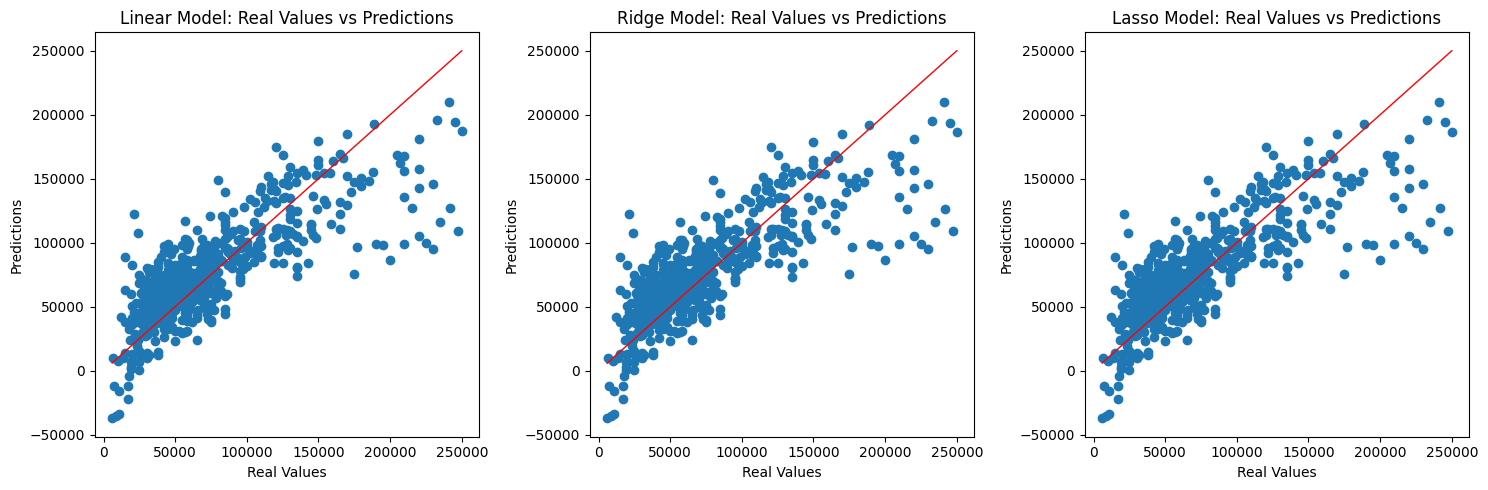

In [70]:
# Linear Model
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=1)
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.title('Linear Model: Real Values vs Predictions')

# Ridge Model
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_ridge)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=1)
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.title('Ridge Model: Real Values vs Predictions')

# Lasso Model
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_lasso)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=1)
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.title('Lasso Model: Real Values vs Predictions')

plt.tight_layout()
plt.show()

#### Residual Histogram

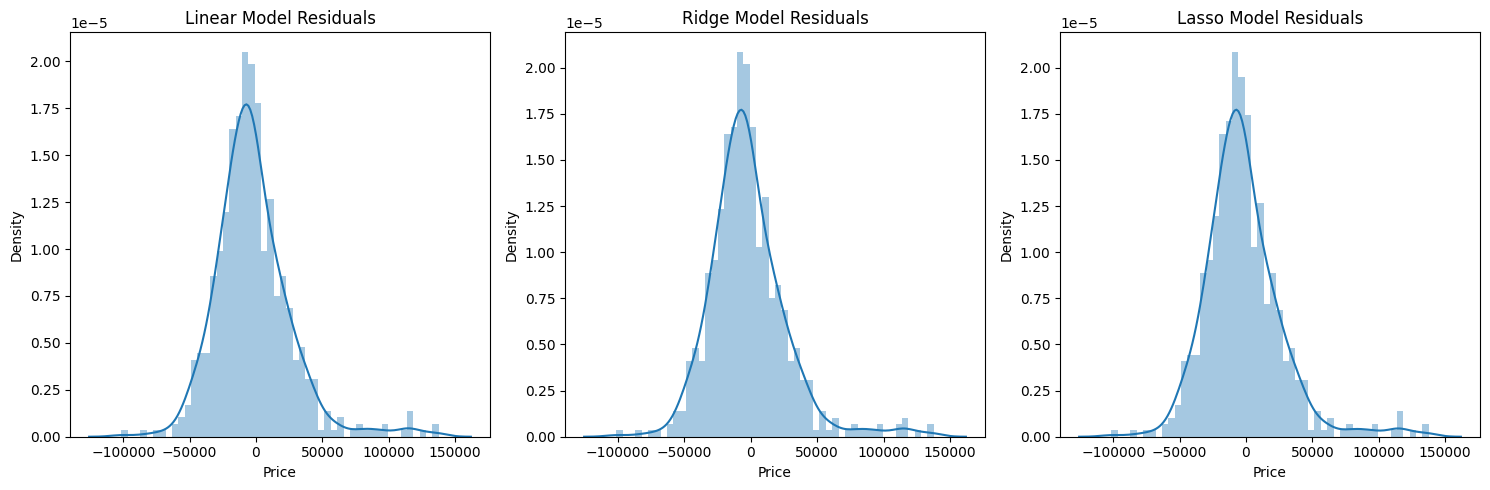

In [72]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.distplot((y_test - y_pred), bins=50)
plt.title('Linear Model Residuals')

plt.subplot(1, 3, 2)
sns.distplot((y_test - y_pred_ridge), bins=50)
plt.title('Ridge Model Residuals')

plt.subplot(1, 3, 3)
sns.distplot((y_test - y_pred_lasso), bins=50)
plt.title('Lasso Model Residuals')

plt.tight_layout()
plt.show()